In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import networkx as nx
from networkx.algorithms import bipartite
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from community import community_louvain # pip install python-louvain
import ast


pd.set_option('display.max_columns', None)

In [2]:
#!pip install wordcloud 

## 1. Az hirdetésekben található elvárások beolvasása

In [3]:
df = pd.read_csv(r"C:\Users\user\PycharmProjects\ws3\programozo_kodolt.csv")
df['id'] = df['id'].astype(str)
df.head()

,id,technologia,attitude,alt_ismeret
0,2664195,"['GO', 'HTML', 'JavaScript', 'NoSQL', 'PHP', '...","['Analitikus gondolkodás', 'Csapatmunka', 'Lel...","['Módszertan', 'Tervezési minták/clean code']"
1,2668423,"['API', 'Ant', 'Build folyamat??', 'CSS', 'Dat...","['Analitikus gondolkodás', 'Csapatmunka', 'Min...","['Hálózat', 'Monitoring eszközök', 'Relációs a..."
2,2668583,"['Angular', 'Frontend', 'Javascript', 'React',...",['Data Science/AI'],[]
3,2668655,"['.NET', 'ASP', 'Angular', 'C#', 'CSS', 'HTML'...","['Precizitás', 'tanulás']",[]
4,2668744,['Java'],[],[]


In [4]:
rows_in_df = len(df)
print(f"Összesen {rows_in_df} hirdetés van")

Összesen 203 hirdetés van


#### A szövegeket itt is kisbetűssé tesszük

In [5]:
def safe_literal_eval_and_clean(text_list_str):
    if pd.isna(text_list_str) or str(text_list_str).strip() == '': # Üres vagy hiányzó értékek kezelése
        return []
    try:
        # ast.literal_eval a stringet listává vagy halmazzá alakítja
        evaluated = ast.literal_eval(text_list_str)
        # Ha lista/halmaz típus, majd tisztítjuk
        if isinstance(evaluated, (list, set)):
            return [item.strip().lower() for item in evaluated]
        else:
            # Ha nem lista vagy halmaz, hanem pl. egyetlen string ( előfordulhat)
            return [str(evaluated).strip().lower()]
    except (ValueError, SyntaxError) as e:
        # Ha nem sikerül kiértékelni (pl. rossz formátumú string),
        # kezeljük üres listaként és írjunk ki figyelmeztetést.
        print(f"Figyelem (ID: {text_list_str}): Hibás formátumú string található: '{text_list_str}'. Hiba: {e}. Üres listaként kezelve.")
        return []

In [6]:
df['technologia_list'] = df['technologia'].apply(safe_literal_eval_and_clean)
df['attitude_list'] = df['attitude'].apply(safe_literal_eval_and_clean)
df['alt_ismeret_list'] = df['alt_ismeret'].apply(safe_literal_eval_and_clean)
df.head()

,id,technologia,attitude,alt_ismeret,technologia_list,attitude_list,alt_ismeret_list
0,2664195,"['GO', 'HTML', 'JavaScript', 'NoSQL', 'PHP', '...","['Analitikus gondolkodás', 'Csapatmunka', 'Lel...","['Módszertan', 'Tervezési minták/clean code']","[go, html, javascript, nosql, php, adatbázis/s...","[analitikus gondolkodás, csapatmunka, lelkesed...","[módszertan, tervezési minták/clean code]"
1,2668423,"['API', 'Ant', 'Build folyamat??', 'CSS', 'Dat...","['Analitikus gondolkodás', 'Csapatmunka', 'Min...","['Hálózat', 'Monitoring eszközök', 'Relációs a...","[api, ant, build folyamat??, css, data science...","[analitikus gondolkodás, csapatmunka, minőségo...","[hálózat, monitoring eszközök, relációs adatbá..."
2,2668583,"['Angular', 'Frontend', 'Javascript', 'React',...",['Data Science/AI'],[],"[angular, frontend, javascript, react, vue.js,...",[data science/ai],[]
3,2668655,"['.NET', 'ASP', 'Angular', 'C#', 'CSS', 'HTML'...","['Precizitás', 'tanulás']",[],"[.net, asp, angular, c#, css, html, javascript...","[precizitás, tanulás]",[]
4,2668744,['Java'],[],[],[java],[],[]


In [7]:
#sajnos kiderült, hogy nem minden kategóriát rakott az AI jó helyre, igy rendezni kell 

### 1b. Az elvárások kategórizálásának beolvasása


In [8]:
kategoria_df = pd.read_excel(r"C:\Users\user\PycharmProjects\ws3\standardizalt_elvarasok_programozo.xlsx")
kategoria_df.head(3)

,Standardizált Elvárás,bkateg,alcsoport
0,.NET,.NET,technologia
1,.NET 8 ismeret,.NET,technologia
2,.NET Core ismeret,.NET,technologia


In [9]:
#legyen minden kisbetűs... 
kategoria_df['bkateg'] = kategoria_df['bkateg'].apply(lambda x: str(x).strip().lower())
kategoria_df['alcsoport'] = kategoria_df['alcsoport'].apply(lambda x: str(x).strip().lower())
kategoria_to_alcsoport = kategoria_df.groupby('bkateg')['alcsoport'].apply(lambda x: list(set(x))).to_dict()

print("Kategoria/alcsoport dict (első 5 bejegyzés):")
# Csak az első 5 elemet írjuk ki, hogy ne legyen túl hosszú
for k, v in list(kategoria_to_alcsoport.items())[:5]:
    print(f"  '{k}': {v}")

Kategoria/alcsoport dict (első 5 bejegyzés):
  '.net': ['technologia']
  '3d/ar/vr': ['technologia']
  'adatbázis/sql': ['technologia']
  'adatközpont': ['általános_ismeret']
  'algoritmus': ['általános_ismeret']


#### Minden itemet egy helyre gyűjtünk, majd a Kategozizás szerint újra szétdobjuk, már a tuti helyére

In [10]:
df['processed_technologia'] = [[] for _ in range(len(df))]
df['processed_attitude'] = [[] for _ in range(len(df))]
df['processed_alt_ismeret'] = [[] for _ in range(len(df))]
df['unclassified_categories'] = [[] for _ in range(len(df))] # Ide kerülnek a besorolatlan kategóriák


#### Sajnos nemcsak a kategória besorolása a rossz, hanem helyenként a csoportképzés is,  ezért csinálunk egy recode-ot. 

In [11]:
recode = {"minőségorientált szemlélet":"minőség","docker":"kontenerizáció",
         "ant":"build folyamat??","kreativitás":"kreativítás",
         "precizitás":"precíz","proaktivitás":"önállóság/kezdeményező",
         "ügyfélközpontúság":"kommunikáció", "eredményorientáltság":"céltudatos",
         "angulár": "angular", "ai":"data science/ai", "asszertív kommunikáció":"kommunikáció",
         "servicenow": "folyamatkezelés/automatizálás", "jira":"verziókezelés/management/git/github/gitlab/jira",
          "git":"verziókezelés/management/git/github/gitlab/jira", "mysql": "adatbázis/sql","sharepoint":"power automate",
          "microsoft power":"power automate", "c": "c/c++",
         "jenkins": "folyamatkezelés/automatizálás", "sql": "adatbázis/sql", "spring":"java", "technologia": "",
         "alt_ismeret": "", "attitude":"", "önállóság":"önállóság/kezdeményező","apache":"web", "agilis":"módszertan",
         "webpack":"web", "socket.io": "javascript", "scrum":"módszertan" , "rest": "api", "maven": "build folyamat??", 
         "middleware":"egyéb", "spring security":"java","postgresql": "adatbázis/sql","testing":"teszt","eclipse":"ide",
         "c++": "c/c++","uml":"folyamatkezelés/automatizálás","stm32":"ipari szoftver", "kanban":"módszertan" , "kubernetes":"kontenerizáció",
          "ansible": "devops", "arm":"ipari szoftver", "gyors tanulás":"tanulás","proaktív hozzáállás":"önállóság/kezdeményező",
          "liferay": "wordpress/liferay", "fastapi": "api", "django":"python","adatbáz/sql":"adatbázis/sql","szervezőkészség":"egyéb attitude", 
          "dinamizmus":"dinamikus"
         }
             

In [12]:
for idx, row in df.iterrows():
    
    # Összegyűjtjük az összes kategóriát egyetlen listába az adott hirdetéshez,
    # az eredeti (már tisztított és listává alakított) oszlopokból.
    # A 'set()' használata itt biztosítja, hogy ha egy kategória többször is szerepel
    # az eredeti oszlopokban (pl. 'PLC' a 'technologia' és 'alt_ismeret' oszlopban is),
    # akkor csak egyszer dolgozzuk fel.
    all_current_categories_for_ad = set()
    all_current_categories_for_ad.update(row['technologia_list'])
    all_current_categories_for_ad.update(row['attitude_list'])
    all_current_categories_for_ad.update(row['alt_ismeret_list'])

    recode_and_clean_categories = set()
    for category in all_current_categories_for_ad:
        recoded_category = recode.get(category, category)
        recode_and_clean_categories.add(recoded_category)
        
    for category in recode_and_clean_categories:
        # Lekérdezzük az XLS fájlból származó leképezésből, hogy ez a kategória mely alcsoport(ok)hoz tartozik.
        mapped_alcsoportok = kategoria_to_alcsoport.get(category)
        if mapped_alcsoportok:
            # Ha a kategória megtalálható az XLS-ben (azaz van hozzá besorolás)
            # Akkor hozzáadjuk a megfelelő 'processed_' listához/listákhoz.
            if 'technologia' in mapped_alcsoportok:
                df.at[idx, 'processed_technologia'].append(category)
            if 'attitude' in mapped_alcsoportok:
                df.at[idx, 'processed_attitude'].append(category)
            if 'alt_ismeret' in mapped_alcsoportok:
                df.at[idx, 'processed_alt_ismeret'].append(category)
        else:
            # Ha a kategória nincs benne az XLS fájlban, akkor besorolatlan.
            # Hozzáadjuk az 'unclassified_categories' listához.
            df.at[idx, 'unclassified_categories'].append(category)
    # ha még maradt volna benne dupla... 
    df.at[idx, 'processed_technologia'] = list(set(df.at[idx, 'processed_technologia']))
    df.at[idx, 'processed_attitude'] = list(set(df.at[idx, 'processed_attitude']))
    df.at[idx, 'processed_alt_ismeret'] = list(set(df.at[idx, 'processed_alt_ismeret'])) 

#irassuk ki azokat a rekordokat, amiket nem sikerült besorolni 
df['unclassified_categories'] = df['unclassified_categories'].apply(
    lambda x: [item for item in x if isinstance(item, str) and item.strip()] if isinstance(x, list) else []
)
df_tmp = df[df['unclassified_categories'].apply(lambda x: len(x) > 0)]
df_tmp

,id,technologia,attitude,alt_ismeret,technologia_list,attitude_list,alt_ismeret_list,processed_technologia,processed_attitude,processed_alt_ismeret,unclassified_categories


## 2. Szófelhő

In [13]:
all_technologies = []
for sublist in df['processed_technologia']:
    for tech in sublist:
        all_technologies.append(tech)

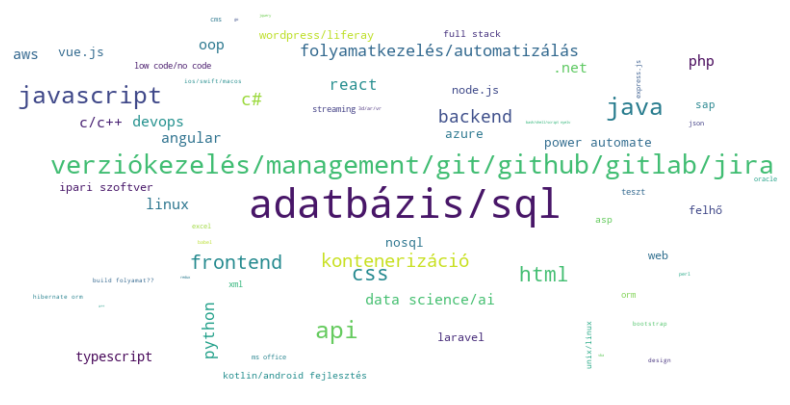

In [14]:
tech_counts = Counter(all_technologies)

# Létrehozzuk a szófelhő objektumot a gyakoriságok alapján
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white'
).generate_from_frequencies(tech_counts)

# Megjelenítjük a szófelhőt
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Látszik, hogy az Adatbázis, a verziókezelés manapság minimálisan szükséges elvárás, de a java, javascript és az API ismeretek is kiemelkedősen fontosak

In [15]:
unique_technologies = sorted(list(set(all_technologies)))
print(f"\nÖsszesen {len(unique_technologies)} egyedi technológia található.")
print(f"Példa technológiák: {unique_technologies[:10]}...") # első 10 technológia



Összesen 81 egyedi technológia található.
Példa technológiák: ['.net', '3d/ar/vr', 'adatbázis/sql', 'angular', 'api', 'asp', 'aws', 'azure', 'babel', 'backend']...


## 3. Vizsgáljuk meg Gráfelméleti módszerekkel az adatokat

In [16]:
print(f"Az összesen {rows_in_df} hirdetés vizsgálata:")
B = nx.Graph()

hirdetes_nodes = df['id'].tolist()
B.add_nodes_from(hirdetes_nodes, bipartite=0, type='hirdetes')
B.add_nodes_from(unique_technologies, bipartite=1, type='processed_technologia')

# Élek hozzáadása a hirdetések és technológiák között
for index, row in df.iterrows():
    hirdetes_id = row['id']
    for tech in row['processed_technologia']:
        B.add_edge(hirdetes_id, tech)

print(f"Hirdetés-technológia gráf csomópontok száma: {B.number_of_nodes()}")
print(f"Hirdetés-technológia gráf élek száma: {B.number_of_edges()}")


# Hipotézis vizsgálata: Hirdetés komplexitása (technológiák száma) ---
# Számoljuk meg, hány technológiát kér egy-egy hirdetés (ez a hirdetés csomópont fokszáma)
hirdetes_fokszamok = {}
for node in hirdetes_nodes:
    hirdetes_fokszamok[node] = B.degree[node]

# Átlagos technológia elvárás hirdetésenként
atlag_tech_per_hirdetes = np.mean(list(hirdetes_fokszamok.values()))
print(f"Átlagos technológiai elvárás hirdetésenként: {atlag_tech_per_hirdetes:.2f}")

# Hány hirdetés kér 3-nál több technológiát?
#magas_komplexitasu_hirdetesek = sum(1 for degree in hirdetes_fokszamok.values() if degree > 3)
magas_komplexitasu_hirdetesek = 0
for degree in hirdetes_fokszamok.values():
    if degree > 3:
        magas_komplexitasu_hirdetesek += 1
print(f"{magas_komplexitasu_hirdetesek} hirdetés kér több mint 3 technológiát.")

magas_komplexitasu_hirdetesek = 0
for degree in hirdetes_fokszamok.values():
    if degree > 5:
        magas_komplexitasu_hirdetesek += 1
print(f"{magas_komplexitasu_hirdetesek} hirdetés kér több mint 5 technológiát.")


Az összesen 203 hirdetés vizsgálata:
Hirdetés-technológia gráf csomópontok száma: 284
Hirdetés-technológia gráf élek száma: 1191
Átlagos technológiai elvárás hirdetésenként: 5.87
133 hirdetés kér több mint 3 technológiát.
96 hirdetés kér több mint 5 technológiát.


### A hírdetések kb felénél kérnek minimum 5 technológiát, kb a 2/3-ánál minimum 3-at

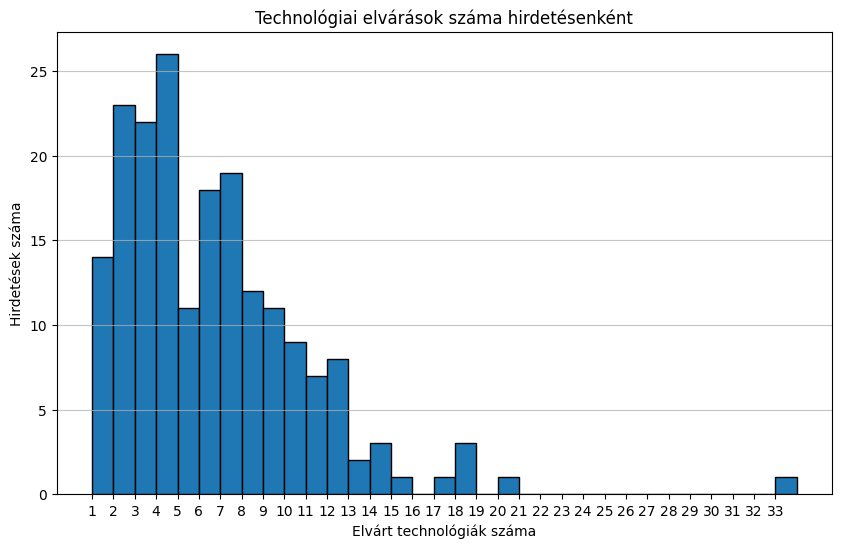

In [17]:
#Technológiai elvárások száma hirdetésenként
plt.figure(figsize=(10, 6))
plt.hist(list(hirdetes_fokszamok.values()), bins=range(1, max(hirdetes_fokszamok.values()) + 2), edgecolor='black')
plt.title('Technológiai elvárások száma hirdetésenként')
plt.xlabel('Elvárt technológiák száma')
plt.ylabel('Hirdetések száma')
plt.xticks(range(1, max(hirdetes_fokszamok.values()) + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

### a 33 technológiai elvárás nem elkódolás, valóban van olyan hírdetés, ahol sok minden fel van sorolva. Nyilván jelen esetben a "vagy" típusú megközelítéseket nem tudtam filgyelmbe venni, részen ez okozza a kiugró értéket. 

In [18]:
tech_fokszamok = {node: B.degree[node] for node in unique_technologies}
legnepszerubb_tech = sorted(tech_fokszamok.items(), key=lambda item: item[1], reverse=True)[:10]
print("\nTop 10 legnépszerűbb technológia:")
for tech, fokszam in legnepszerubb_tech:
    print(f"  - {tech}: {fokszam} hirdetés")


Top 10 legnépszerűbb technológia:
  - adatbázis/sql: 107 hirdetés
  - verziókezelés/management/git/github/gitlab/jira: 77 hirdetés
  - java: 65 hirdetés
  - javascript: 65 hirdetés
  - api: 63 hirdetés
  - css: 43 hirdetés
  - html: 42 hirdetés
  - frontend: 39 hirdetés
  - kontenerizáció: 36 hirdetés
  - backend: 33 hirdetés


### az adatbázisismeretek és a verziókezelés/management annyira evidens elvárás, hogy igazából ki is kellene hagyni az elemzésből :)

## 4. Technológiai kapcsolatok ábrázolása

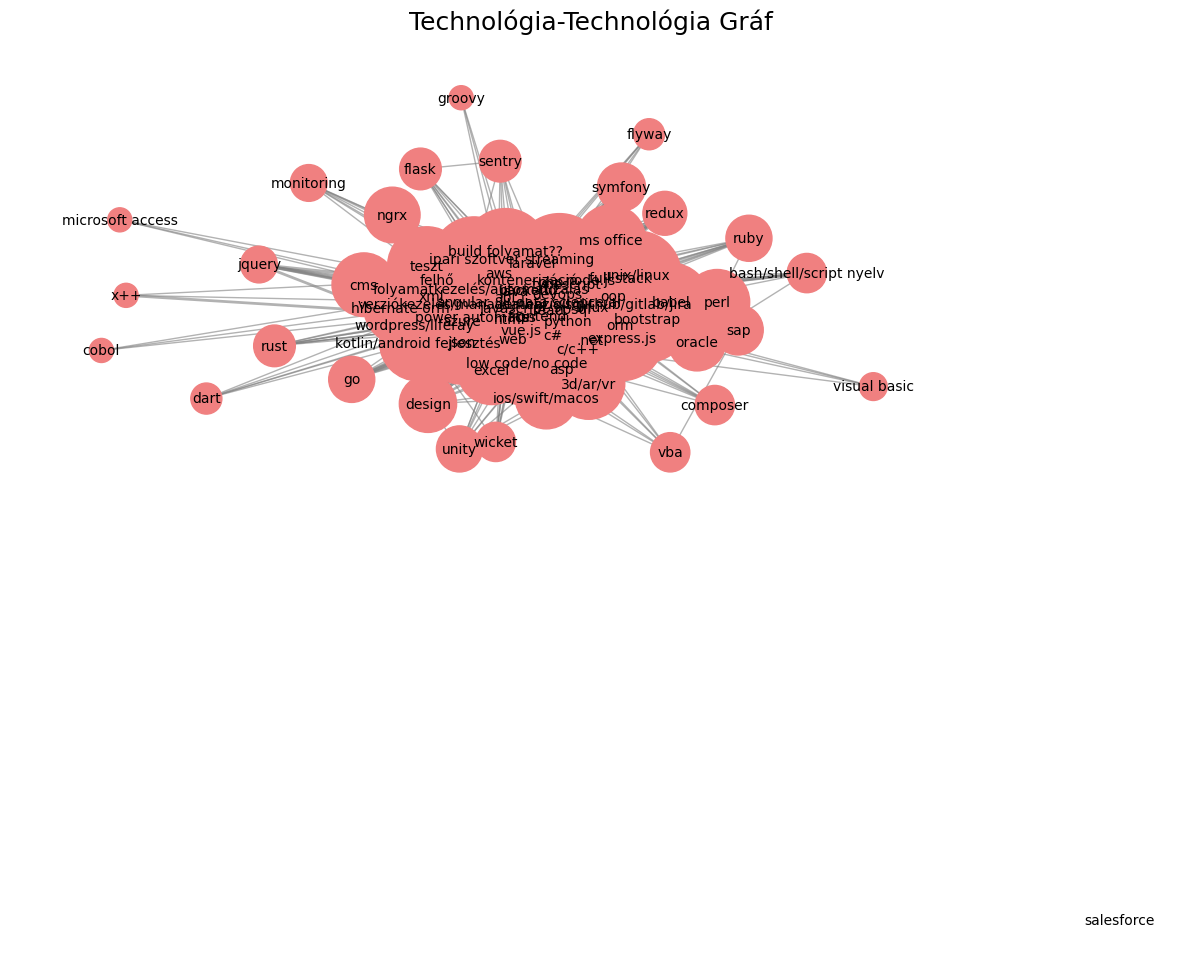

In [19]:


tech_graph = bipartite.weighted_projected_graph(B, unique_technologies)

plt.figure(figsize=(15, 12))
pos = nx.spring_layout(tech_graph, k=0.3)  # Elrendezés meghatározása

# A csomópontok mérete a fokszámmal arányos, jelezve a technológia népszerűségét.
node_sizes = [tech_graph.degree(node) * 100 for node in tech_graph.nodes()]

# Az élek vastagsága a súlyukkal arányos, jelezve az előfordulás gyakoriságát.
edge_weights = [d['weight'] for u, v, d in tech_graph.edges(data=True)]

nx.draw_networkx_nodes(tech_graph, pos, node_size=node_sizes, node_color='lightcoral')
nx.draw_networkx_edges(tech_graph, pos, width=edge_weights, alpha=0.6, edge_color='gray')

# Címkék hozzáadása
labels = {node: node for node in tech_graph.nodes()}
nx.draw_networkx_labels(tech_graph, pos, labels=labels, font_size=10, font_color='black')

plt.title("Technológia-Technológia Gráf", fontsize=18)
plt.axis('off')
plt.show()

In [20]:
### A SalesForce annyir önálló szakma, hogy outlier-ként viselkedik. Érdemes lenne külön elemezni, de most töröljük az állományból

In [21]:
B.remove_node('salesforce')
if 'salesforce' in unique_technologies:
    unique_technologies.remove('salesforce')

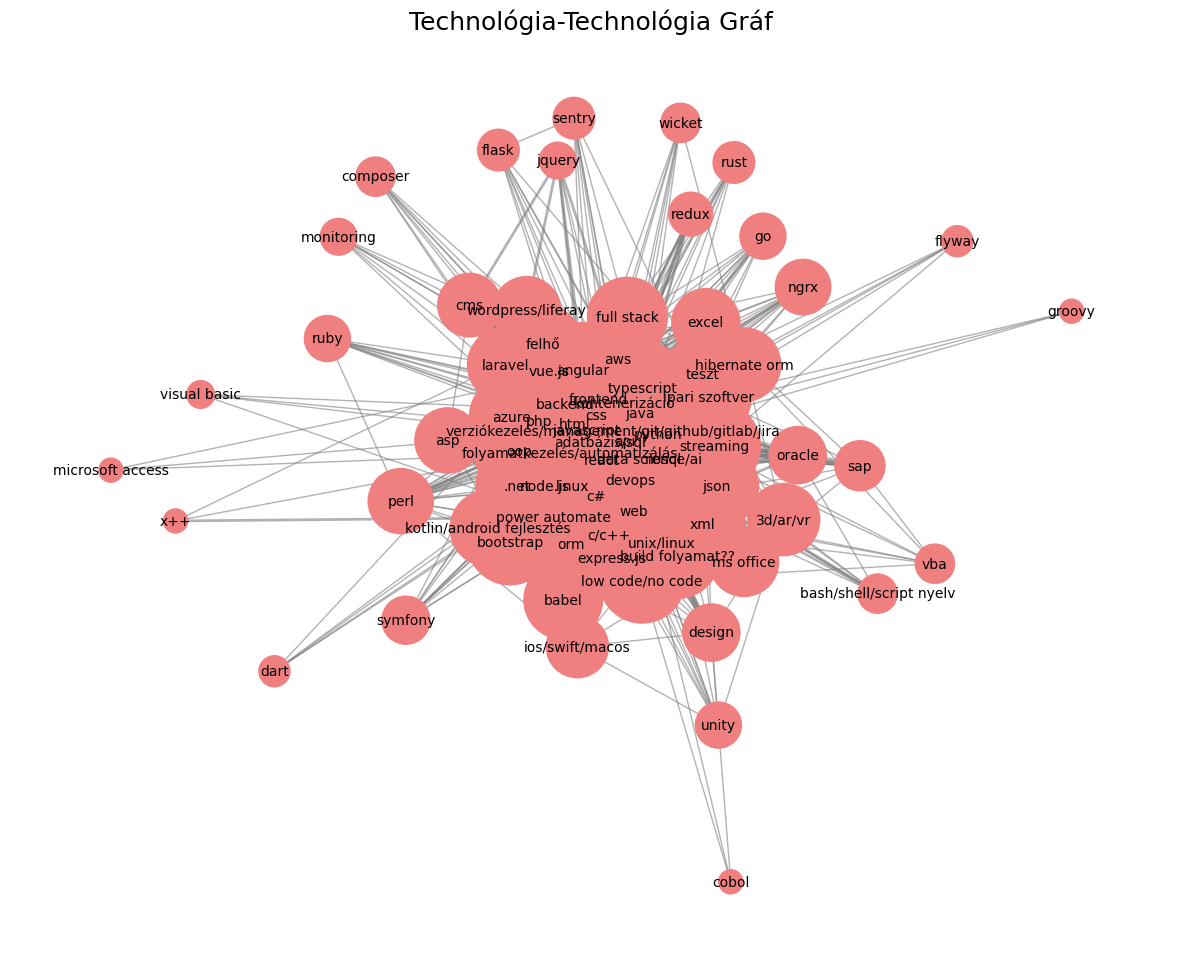

In [22]:


tech_graph = bipartite.weighted_projected_graph(B, unique_technologies)

plt.figure(figsize=(15, 12))
pos = nx.spring_layout(tech_graph, k=0.3)  # Elrendezés meghatározása

# A csomópontok mérete a fokszámmal arányos, jelezve a technológia népszerűségét.
node_sizes = [tech_graph.degree(node) * 100 for node in tech_graph.nodes()]

# Az élek vastagsága a súlyukkal arányos, jelezve az előfordulás gyakoriságát.
edge_weights = [d['weight'] for u, v, d in tech_graph.edges(data=True)]

nx.draw_networkx_nodes(tech_graph, pos, node_size=node_sizes, node_color='lightcoral')
nx.draw_networkx_edges(tech_graph, pos, width=edge_weights, alpha=0.6, edge_color='gray')

# Címkék hozzáadása
labels = {node: node for node in tech_graph.nodes()}
nx.draw_networkx_labels(tech_graph, pos, labels=labels, font_size=10, font_color='black')

plt.title("Technológia-Technológia Gráf", fontsize=18)
plt.axis('off')
plt.show()

## 4b. Top 10 item ábrázolása

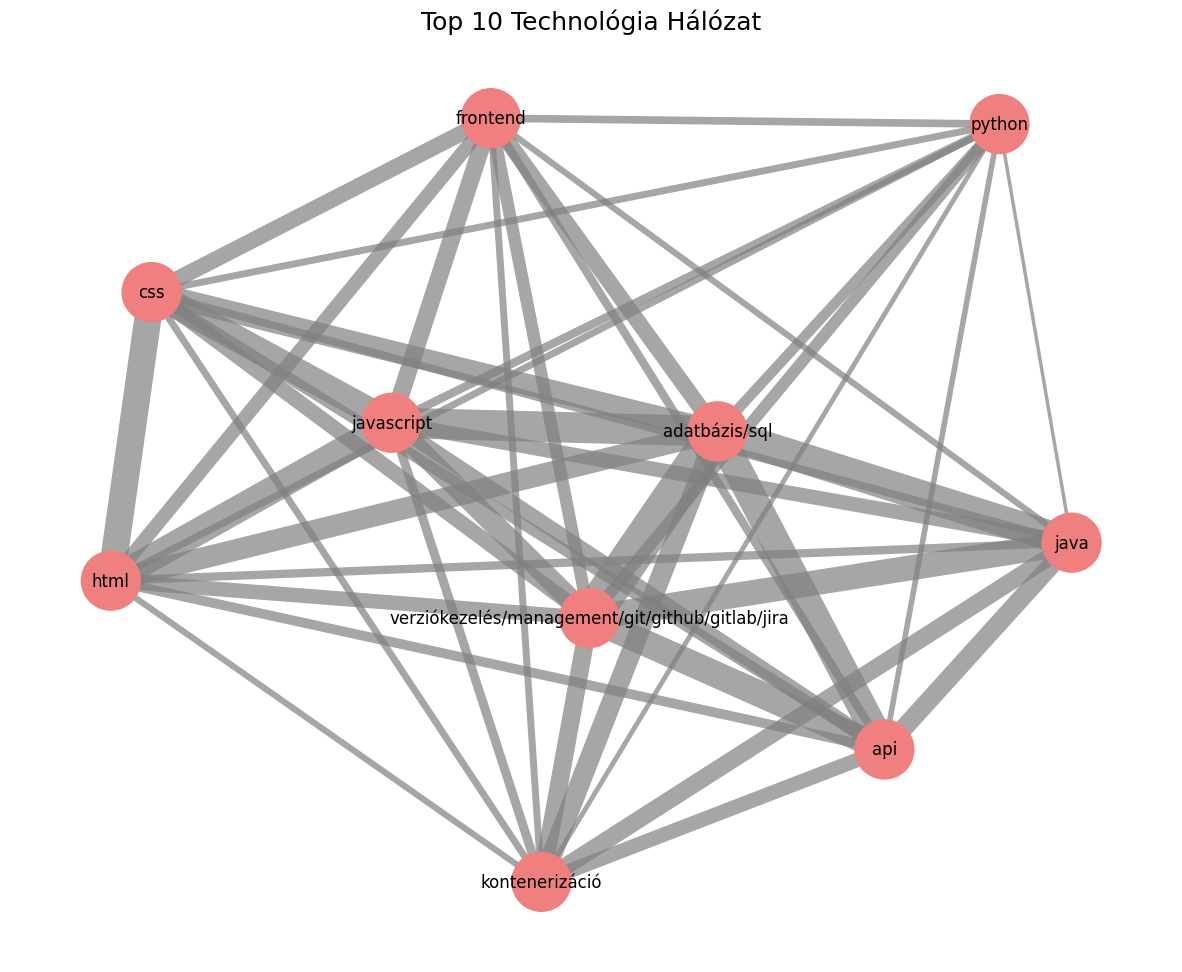

In [23]:

# A technológia csomópontokra projektálás, az eredeti, nem szűrt listát használva.
tech_graph = bipartite.weighted_projected_graph(B, unique_technologies)

# Megkeressük a 10 legnépszerűbb technológiát (a legnagyobb fokszámú csomópontokat).
# A .degree() egy dictionary-szerű objektumot ad vissza, amit rendezni lehet.
top_10_technologies = sorted(tech_graph.degree, key=lambda x: x[1], reverse=True)[:10]
top_10_nodes = [node for node, degree in top_10_technologies]

# Létrehozunk egy új, részleges gráfot, ami csak a 10 legfontosabb csomópontot tartalmazza.
# Ezt a "fő hálózatot" emeljük ki az eredeti gráfon.
subgraph = tech_graph.subgraph(top_10_nodes)

plt.figure(figsize=(15, 12))
# A k értékét növelve a csomópontok jobban elkülönülnek.
pos = nx.spring_layout(subgraph, k=0.5, iterations=50)

# A csomópontok mérete a fokszámmal arányos, a fontossági sorrend megmarad.
node_sizes = [subgraph.degree(node) * 200 for node in subgraph.nodes()]

# Az élek vastagsága a súlyukkal arányos.
edge_weights = [d['weight'] * 0.5 for u, v, d in subgraph.edges(data=True)]

nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='lightcoral')
nx.draw_networkx_edges(subgraph, pos, width=edge_weights, alpha=0.7, edge_color='gray')

# Címkék hozzáadása
labels = {node: node for node in subgraph.nodes()}
nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=12, font_color='black')

plt.title("Top 10 Technológia Hálózat", fontsize=18)
plt.axis('off')
plt.show()

#### A fentiek legfontosabb ismeretek a programozóknál általában.... 
#### Minden mindennel kapcsolatban van.... 

## 4c. Tegyük fel, hogy minden programozó az 
- általánosban összeszedte a html, css ismereteket, 
- középiskolában az adatbáziskezelést, verziókezelés/managementet és a javascriptet
  
akkor mit tanuljon felsőfokon?


In [24]:
# A hálózati elemzési kód

# 1. Kiszűrjük a "mindenki számára ismert" technológiákat.
kizart_technologiak = ['adatbázis/sql', 'html', 'css', 'javascript', 'verziókezelés/management/git/github/gitlab/jira']

# Új oszlop létrehozása a szűrt technológiáknak
df['processed_technologia_szurt'] = df['processed_technologia'].apply(
    lambda x: [tech for tech in x if tech.lower() not in kizart_technologiak]
)

# A maradék egyedi technológiák összegyűjtése.
unique_technologies_szurt = set()
for sublist in df['processed_technologia_szurt']:
    unique_technologies_szurt.update(sublist)

# 2. Hálózati gráf felépítése a szűrt adatokkal
B_filtered = nx.Graph()

# Hozzáadjuk a hirdetés csomópontokat (típussal)
hirdetes_nodes = df['id'].tolist()
B_filtered.add_nodes_from(hirdetes_nodes, bipartite=0, type='hirdetes')
B_filtered.add_nodes_from(unique_technologies_szurt, bipartite=1, type='processed_technologia')

# Élek hozzáadása a hirdetések és a SZŰRT technológiák között
for index, row in df.iterrows():
    hirdetes_id = row['id']
    # Itt az új, szűrt oszlopot használjuk
    for tech in row['processed_technologia_szurt']:
        B_filtered.add_edge(hirdetes_id, tech)

print(f"Hirdetés-technológia gráf csomópontok száma: {B.number_of_nodes()}")
print(f"Hirdetés-technológia gráf élek száma: {B.number_of_edges()}")

# A további elemzések (átlagos fokszám, projekció)
# szintén a szűrt gráfon futnak tovább.

Hirdetés-technológia gráf csomópontok száma: 283
Hirdetés-technológia gráf élek száma: 1190


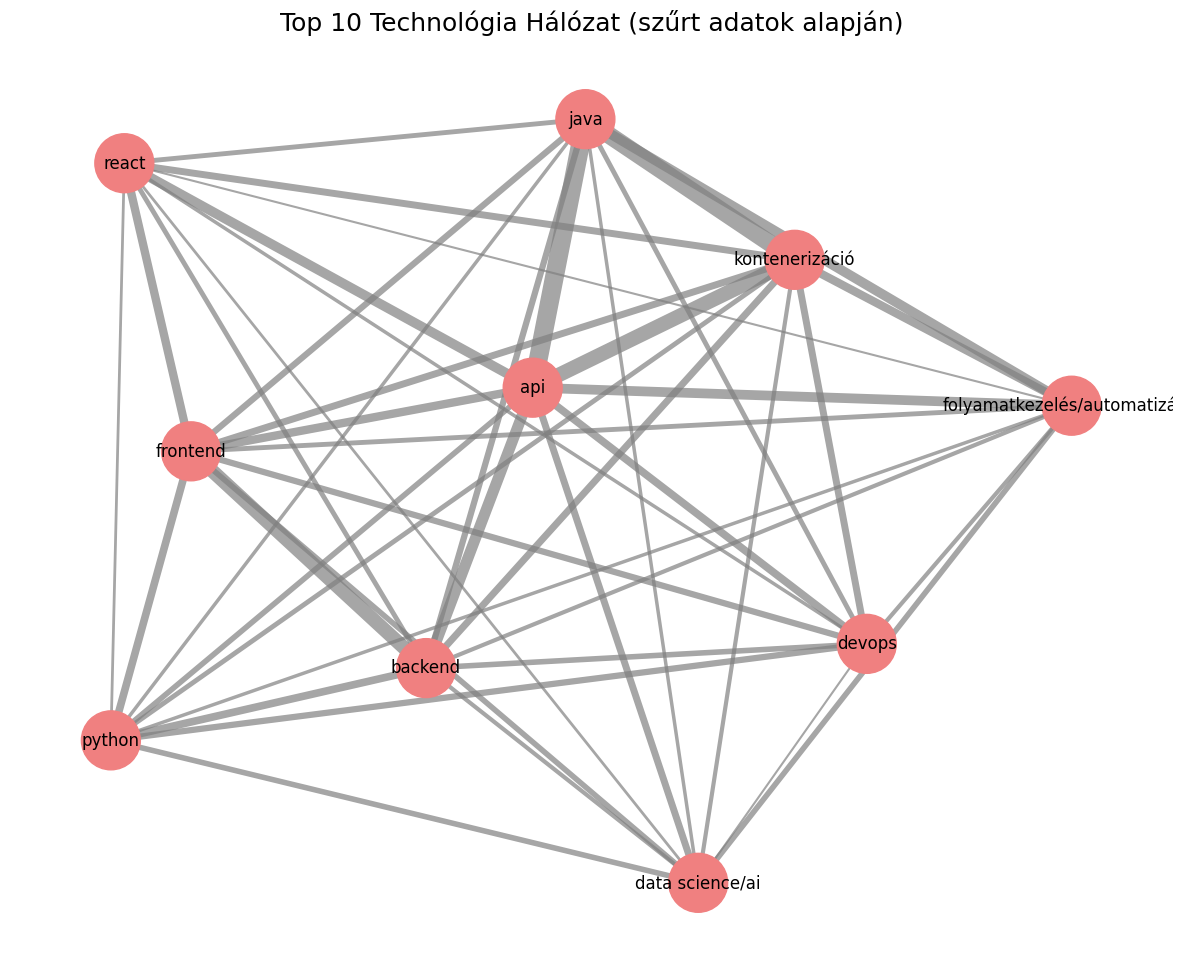

In [26]:


# A technológia csomópontokra projektálás, az eredeti, nem szűrt listát használva.
tech_graph = bipartite.weighted_projected_graph(B_filtered, unique_technologies_szurt)

# Megkeressük a 10 legnépszerűbb technológiát (a legnagyobb fokszámú csomópontokat).
top_10_technologies = sorted(tech_graph.degree, key=lambda x: x[1], reverse=True)[:10]
top_10_nodes = [node for node, degree in top_10_technologies]

# Létrehozunk egy új, részleges gráfot, ami csak a 10 legfontosabb csomópontot tartalmazza.
# Ezt a "fő hálózatot" emeljük ki az eredeti gráfon.
subgraph = tech_graph.subgraph(top_10_nodes)

plt.figure(figsize=(15, 12))
# A k értékét növelve a csomópontok jobban elkülönülnek.
pos = nx.spring_layout(subgraph, k=0.5, iterations=50)

# A csomópontok mérete a fokszámmal arányos, a fontossági sorrend megmarad.
node_sizes = [subgraph.degree(node) * 200 for node in subgraph.nodes()]

# Az élek vastagsága a súlyukkal arányos.
edge_weights = [d['weight'] * 0.5 for u, v, d in subgraph.edges(data=True)]

nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='lightcoral')
nx.draw_networkx_edges(subgraph, pos, width=edge_weights, alpha=0.7, edge_color='gray')

# Címkék hozzáadása
labels = {node: node for node in subgraph.nodes()}
nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=12, font_color='black')

plt.title("Top 10 Technológia Hálózat (szűrt adatok alapján)", fontsize=18)
plt.axis('off')
plt.show()

### Hát kedves kollégák ez az elvárás.... Bármennyire is furi itt a "Frontend" és a "Backend" a humánpolitika igy ismeri..

## 5. Hány szakmát is keresnek a munkaadók egy programozóban???


In [38]:
# A technológia csomópontokra projektálás, ahol a súlyok a közös szomszédok száma.
# A weighted_projected_graph metódus garantálja a súlyozást.
tech_graph = bipartite.weighted_projected_graph(B, unique_technologies)

# A leggyakoribb technológia párok kiírása
leggyakoribb_tech_parok = sorted(tech_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:20]
print("\n20 leggyakoribb technológia páros (együtt fordulnak elő):")
for u, v, data in leggyakoribb_tech_parok:
    print(f"  - ({u}, {v}) - {data['weight']} alkalommal")


20 leggyakoribb technológia páros (együtt fordulnak elő):
  - (adatbázis/sql, verziókezelés/management/git/github/gitlab/jira) - 56 alkalommal
  - (adatbázis/sql, java) - 44 alkalommal
  - (adatbázis/sql, javascript) - 44 alkalommal
  - (adatbázis/sql, api) - 42 alkalommal
  - (css, html) - 39 alkalommal
  - (html, javascript) - 39 alkalommal
  - (api, verziókezelés/management/git/github/gitlab/jira) - 38 alkalommal
  - (css, javascript) - 38 alkalommal
  - (java, verziókezelés/management/git/github/gitlab/jira) - 36 alkalommal
  - (adatbázis/sql, html) - 31 alkalommal
  - (adatbázis/sql, css) - 31 alkalommal
  - (javascript, verziókezelés/management/git/github/gitlab/jira) - 31 alkalommal
  - (adatbázis/sql, kontenerizáció) - 29 alkalommal
  - (api, java) - 27 alkalommal
  - (kontenerizáció, verziókezelés/management/git/github/gitlab/jira) - 26 alkalommal
  - (adatbázis/sql, c#) - 25 alkalommal
  - (frontend, javascript) - 25 alkalommal
  - (java, kontenerizáció) - 25 alkalommal
  - 

## 5b. Hány szakmát is keresnek a munkaadók egy programozóban??? Mert ugye az adatbázis, html, css, verziókezelés/management és a javascript már megy... 


In [29]:

# A technológia csomópontokra projektálás, a szűrt listát használva.
tech_graph = bipartite.weighted_projected_graph(B_filtered, unique_technologies_szurt)

# A leggyakoribb technológia párok kiírása
leggyakoribb_tech_parok = sorted(tech_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10]
print("\n10 leggyakoribb technológia páros (együtt fordulnak elő):")
for u, v, data in leggyakoribb_tech_parok:
    print(f"  - ({u}, {v}) - {data['weight']} alkalommal")


10 leggyakoribb technológia páros (együtt fordulnak elő):
  - (java, api) - 27 alkalommal
  - (kontenerizáció, java) - 25 alkalommal
  - (kontenerizáció, api) - 21 alkalommal
  - (frontend, backend) - 20 alkalommal
  - (.net, c#) - 18 alkalommal
  - (backend, api) - 16 alkalommal
  - (folyamatkezelés/automatizálás, api) - 14 alkalommal
  - (folyamatkezelés/automatizálás, java) - 14 alkalommal
  - (aws, api) - 14 alkalommal
  - (react, api) - 14 alkalommal


### Mindenki döntse el maga, hogy mit olvas ki a fentiekből


# +1.  Közösségdetektálás avagy validáljuk az adatainkat

## A közösségdetektálás célja, hogy megtalálja a hálózaton belüli szorosan összekapcsolódó csomópontokat, amelyek egy csoportot (közösséget) alkotnak.

In [31]:

# Technológia-Technológia Hasonlósági Gráf és Közösségdetektálás ---
print("\nTechnológia-Technológia Hasonlósági Gráf és Közösségdetektálás...")

# Projektáljuk a kéttényezős gráfot technológia-technológia gráffá
# Ez azt jelenti, hogy két technológia akkor kapcsolódik, ha együtt szerepelnek egy hirdetésben.
# Az él súlya lehet az együtt előfordulások száma.
technology_graph = nx.Graph()

# MultiLabelBinarizer: Segít egy mátrixot létrehozni, ahol a sorok hirdetések, az oszlopok technológiák
mlb = MultiLabelBinarizer()
tech_matrix = mlb.fit_transform(df['processed_technologia'])
tech_df = pd.DataFrame(tech_matrix, columns=mlb.classes_)

# Számoljuk az együtt előfordulásokat
co_occurrence_matrix = tech_df.T.dot(tech_df)

# Élek hozzáadása a technológia gráfhoz
for i, tech1 in enumerate(mlb.classes_):
    for j, tech2 in enumerate(mlb.classes_):
        if i < j and co_occurrence_matrix.iloc[i, j] > 0: # Csak ha együtt fordulnak elő
            technology_graph.add_edge(tech1, tech2, weight=co_occurrence_matrix.iloc[i, j])

print(f"Technológia-technológia gráf csomópontok száma: {technology_graph.number_of_nodes()}")
print(f"Technológia-technológia gráf élek száma: {technology_graph.number_of_edges()}")


Technológia-Technológia Hasonlósági Gráf és Közösségdetektálás...
Technológia-technológia gráf csomópontok száma: 80
Technológia-technológia gráf élek száma: 1287


In [32]:
print("\nKözösségdetektálás futtatása (Louvain algoritmus)...")
partition = community_louvain.best_partition(technology_graph, weight='weight')
num_communities = max(partition.values()) + 1
print(f"Talált közösségek száma: {num_communities}")

# Közösségek kiírása
communities = {}
for node, comm_id in partition.items():
    if comm_id not in communities:
        communities[comm_id] = []
    communities[comm_id].append(node)

for comm_id, members in communities.items():
    print(f"\nKözösség {comm_id} ({len(members)} tag):")
    print(members)




Közösségdetektálás futtatása (Louvain algoritmus)...
Talált közösségek száma: 4

Közösség 2 (13 tag):
['.net', 'adatbázis/sql', 'asp', 'c#', 'excel', 'ms office', 'oop', 'oracle', 'power automate', 'vba', 'bash/shell/script nyelv', 'sap', 'x++']

Közösség 0 (23 tag):
['angular', 'backend', 'css', 'frontend', 'html', 'javascript', 'perl', 'php', 'react', 'typescript', 'full stack', 'bootstrap', 'cms', 'composer', 'go', 'laravel', 'redux', 'ruby', 'rust', 'vue.js', 'wordpress/liferay', 'jquery', 'microsoft access']

Közösség 1 (28 tag):
['api', 'azure', 'data science/ai', 'felhő', 'folyamatkezelés/automatizálás', 'java', 'kotlin/android fejlesztés', 'verziókezelés/management/git/github/gitlab/jira', 'aws', 'hibernate orm', 'ipari szoftver', 'kontenerizáció', 'nosql', 'streaming', 'build folyamat??', 'cobol', 'flask', 'flyway', 'json', 'sentry', 'symfony', 'teszt', 'xml', 'ngrx', 'dart', 'groovy', 'monitoring', 'wicket']

Közösség 3 (16 tag):
['c/c++', 'devops', 'ios/swift/macos', 'low c

A Louvain algoritmus 4 fő közösséget azonosított.

### Közösség 2: Microsoft Stack

    ['.net', 'adatbázis/sql', 'asp', 'c#', 'excel', 'ms office', 'oop', 'oracle', 'power automate', 'vba', 'bash/shell/script nyelv', 'sap', 'x++']


Ez a csoport a klasszikus Microsoft Stack-re és a vállalati környezetben gyakran használt technológiákra fókuszál. Az MS Office, Excel, VBA és Power Automate egyértelműen az irodai automatizáláshoz és üzleti applikációkhoz kapcsolódnak. A .NET, C#, ASP a Microsoft fejlesztői keretrendszerének alapvető elemei, míg az SAP és X++ (ami az MS Dynamics ERP-hez köthető) a nagyvállalati rendszerekre utalnak.

### Közösség 0: Webfejlesztés: Frontend és Backend

    ['angular', 'backend', 'css', 'frontend', 'html', 'javascript', 'perl', 'php', 'react', 'typescript', 'full stack', 'bootstrap', 'cms', 'composer', 'go', 'laravel', 'redux', 'ruby', 'rust', 'vue.js', 'wordpress/liferay', 'jquery', 'microsoft access']


 Ez a legnagyobb csoport, ami nem véletlen, hiszen a webfejlesztés a legszélesebb körben elterjedt terület. Itt találhatóak a klasszikus frontend technológiák, mint a JavaScript, HTML és CSS, valamint a React, Angular és Vue.js keretrendszerek. De ide tartoznak a backend nyelvek is, mint a PHP és a Go, ami a full stack pozíciók gyakoriságát is tükrözi. A CMS (Content Management System) és a WordPress is logikusan illeszkednek ide.

### Közösség 1: (Java/Felhő/Egyéb)

    ['api', 'azure', 'data science/ai', 'felhő', 'folyamatkezelés/automatizálás', 'java', 'kotlin/android fejlesztés', 'verziókezelés/management/git/github/gitlab/jira', 'aws', 'hibernate orm', 'ipari szoftver', 'kontenerizáció', 'nosql', 'streaming', 'build folyamat??', 'cobol', 'flask', 'flyway', 'json', 'sentry', 'symfony', 'teszt', 'xml', 'ngrx', 'dart', 'groovy', 'monitoring', 'wicket']


Ez a közösség egyfajta „gyűjtőcsoport”, ahol a Java mint domináns nyelv körül szerveződnek a technológiák. Ide tartoznak a felhőalapú szolgáltatások (AWS, Azure), az API fejlesztés, a NoSQL adatbázisok és a streaming technológiák. Ez a csoport a komplex, nagy rendszerek fejlesztésére, a felhőalapú architektúrákra és a folyamatosan futó szolgáltatásokra fókuszál.

### Közösség 3: (DevOps/Rendszeradminisztráció/Egyéb)

    ['c/c++', 'devops', 'ios/swift/macos', 'low code/no code', 'orm', 'python', 'unix/linux', 'web', '3d/ar/vr', 'design', 'express.js', 'unity', 'babel', 'linux', 'node.js', 'visual basic']

Ez a közösség egy technológiailag szétszórtabb csoportnak tűnik, de a Python, Unix/Linux és DevOps szavak a rendszerfejlesztési és üzemeltetési feladatokat tükrözik. A Node.js és az Express.js a szerveroldali JavaScriptre utalnak, míg az iOS/Swift, a 3D/AR/VR és az Unity a mobil- és játékfejlesztés, a 3D-s alkalmazások területére utalnak.